<a href="https://colab.research.google.com/github/hadine30/Human-activity-detection/blob/main/M2_RFA_CCTP_pytorch_sujet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrôle de TP M2 IARF-Rodeco

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquemens de feu, tic-tac d'une horloge, le bruit d'un coq, etc...).

Les fichiers audio sont convertis en spectrogramme, une représentation temps/fréquence du signal qui peut être vue comme une image.


### Importation des bibliothèques

Premièrement, faisons les importations nécessaires

In [39]:
import os
import random
import requests
import zipfile
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui va se charger d'ouvrir les fichiers audio et d'en extraire le spectrogramme qui sera traité ensuite comme une image dans la suite.

In [40]:
!pip -q install librosa
import librosa
import librosa.display

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classifier les différents fichiers audio suivant les 10 classes.

#### Téléchargement du corpus

On récupère tout d'abord le corpus

In [41]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2021-10-21 15:57:22--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  10.7MB/s    in 11s     

2021-10-21 15:57:35 (10.7 MB/s) - ‘dataset.zip’ saved [128685900/128685900]

replace data/test/chainsaw/1-64398-B-41.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [42]:
base_dir = './data'

les données que nous allons utiliser sont des données sonore qui sont sur 10 classes que nous avons transformé en spectrogramme pour qu'on puissent les utiliser comme etant des images.
train....8*4*10
test....8*10

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [43]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y, sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))
                    
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [44]:
# Le chargement des données est assez long : environ 2 min
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 2min 30s, sys: 40.4 s, total: 3min 10s
Wall time: 2min 24s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [45]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [46]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[220] = 6 -> rain
• y_train[99] = 3 -> crying_baby
• y_train[257] = 8 -> sea_waves
• y_train[162] = 5 -> helicopter
• y_train[1] = 0 -> chainsaw
• y_train[128] = 4 -> dog
• y_train[280] = 8 -> sea_waves
• y_train[16] = 0 -> chainsaw
• y_train[8] = 0 -> chainsaw
• y_train[93] = 2 -> crackling_fire


**Affichage des images**

On affiche maintenant quelques images issues du corpus avec le label associé

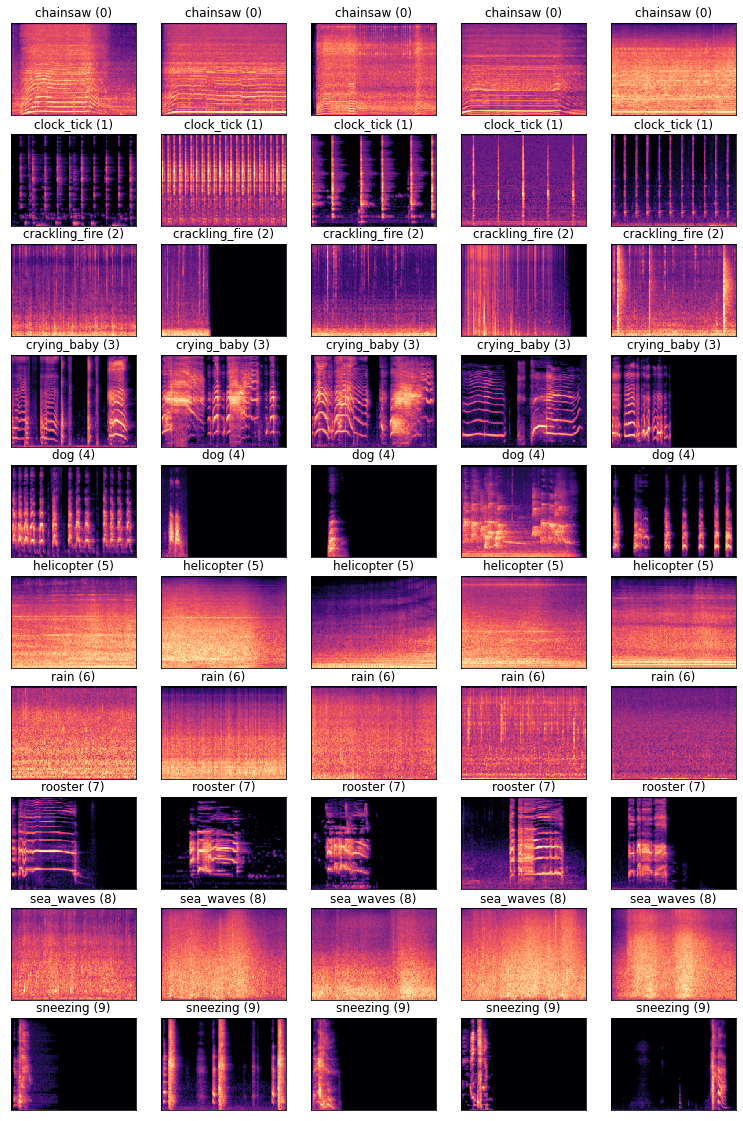

In [47]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        # img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

In [48]:
x_train[0].shape

(128, 216)

# Générateurs de données pour Pytorch

Création d'un générateur de données (un « DataLoader ») pour les jeux de train et de test

In [49]:
nb_classes = 10

# numpy vers tensors
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


height = x_train[0].shape[0]
width = x_train[0].shape[1]
print(height, width)

# numpy vers tensors
X_train = torch.from_numpy(x_train)
X_test = torch.from_numpy(x_test)


128 216


In [50]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)

In [51]:
batch_size=32

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devez :
* complèter l'architecture MLP puis celle du CNN plus bas;
* lancer l'apprentissage ;
* évaluer les modèles sur le jeu de test ;


### Réseau MLP

Dans cette section, il faut compléter le réseau dense ci-dessous, qui contient une couche cachée avec la fonction d'activation ReLU et une couche de sortie

In [52]:
# Perceptron multi-couche 
class MLP(nn.Module):
    def __init__(self, num_hidden=50):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(128 * 216  , num_hidden)
        
        # self.layer12 = nn.Linear(num_hidden  , num_hidden//2)
        # self.layer2 = nn.Linear(num_hidden//2, 10)

        self.layer2 = nn.Linear(num_hidden, 10)

        self.num_hidden = num_hidden
        # vous pouvez définir d'autres couches dans un deuxième temps

    def forward(self, spectro):
        flattened = spectro.view(-1,128 * 216) # flatten le spectro
        activation1 = self.layer1(flattened)
        activation1 = torch.relu(activation1)

        # activation12 = self.layer12(activation1)
        # activation12 = torch.relu(activation12)
        # activation2 = self.layer2(activation12)
        
        activation2 = self.layer2(activation1)
        return activation2


In [79]:
class MLPBN(nn.Module):
    def __init__(self, num_hidden):
        super(MLPBN, self).__init__()
        self.layer1 = nn.Linear(128*216, num_hidden)
        self.bn = nn.BatchNorm1d(num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1, 128*216) # flatten 
        activation1 = self.layer1(flattened)
        activation1 = torch.relu(activation1)
        activation1 = self.bn(activation1)
        activation2 = self.layer2(activation1)
        return activation2



Voici la fonction d'apprentissage, pas de modifications à faire ici

In [53]:
def train(model, batch_size=32, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9, 
          num_epochs=10):
    
    # la loss 
    criterion = nn.CrossEntropyLoss()
    # l'optimiseur
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            # if imgs.size()[0] < batch_size:
            #     continue
            # print(imgs.size())

            model.train() # met le modèle en mode train
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # sauvegarde iteration et loss
            iters.append(n)
            losses.append(float(loss)/batch_size)             # loss moyen

            if n % 20 == 0 :
              train_acc.append(get_accuracy(model, train=True)) # training accuracy 
              val_acc.append(get_accuracy(model, train=False))  # test accuracy
              iters_acc.append(n)

            n += 1

    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [54]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        output = model(inp) # pas besoin de torch.softmax
        pred = output.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        # print(inp,":",pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return correct / total

Instancier un MLP avec 50 neurones pour la couche cachée. Quel est le nombre de paramètres de ce modèle ?

In [83]:
model = MLP(50)
print(model)

MLP(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)


In [84]:
def print_num_parameters(model):
    print("Nombre de paramètres :",
          sum(p.numel() for p in model.parameters()))


In [85]:
print_num_parameters(model)

Nombre de paramètres : 1382960


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

adam

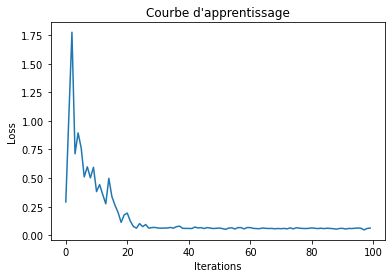

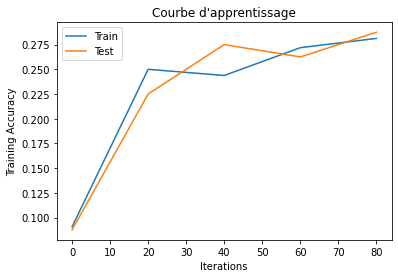

Précision finale Train : 0.28125
Précision finale Test : 0.2875


In [86]:
train(model , optimizer="adam", learning_rate=0.0001, momentum=0.9, num_epochs=10)

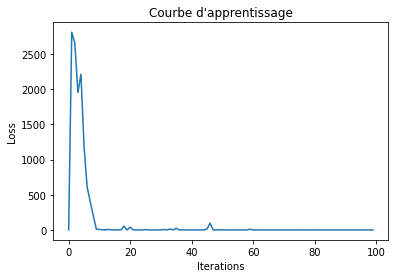

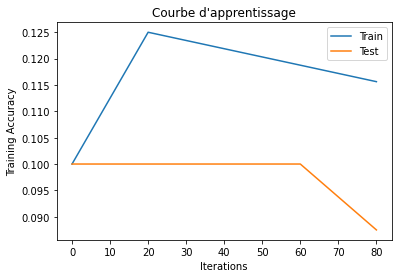

Précision finale Train : 0.115625
Précision finale Test : 0.0875


In [87]:
model = MLP(50)
train(model , optimizer="adam", learning_rate=0.1, momentum=0.9, num_epochs=10)

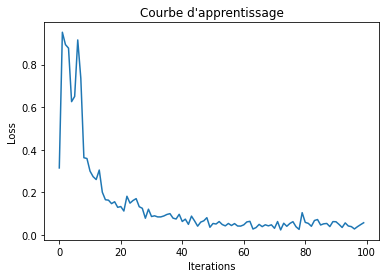

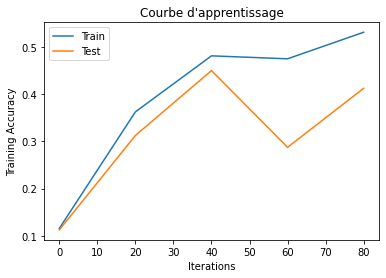

Précision finale Train : 0.53125
Précision finale Test : 0.4125


In [88]:
model = MLP(50)
train(model , optimizer="adam", learning_rate=0.0001, momentum=0., num_epochs=10)

Batch Normalization (adam)


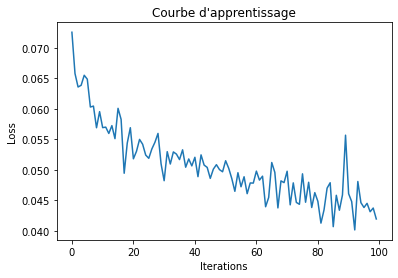

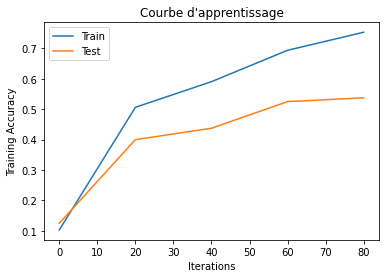

Précision finale Train : 0.753125
Précision finale Test : 0.5375


In [89]:
mlp_bn = MLPBN(50)
train(mlp_bn, optimizer="adam", learning_rate=0.0001, momentum=0.9, num_epochs=10)

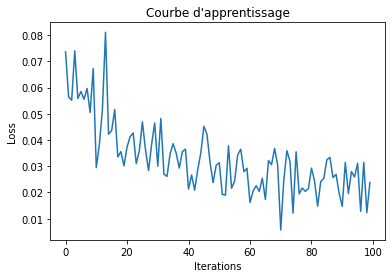

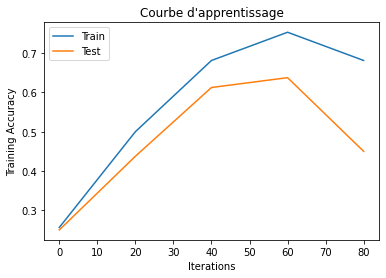

Précision finale Train : 0.68125
Précision finale Test : 0.45


In [90]:
mlp_bn = MLPBN(50)
train(mlp_bn, optimizer="adam", learning_rate=0.1, momentum=0.9, num_epochs=10)

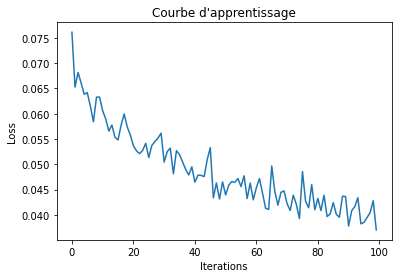

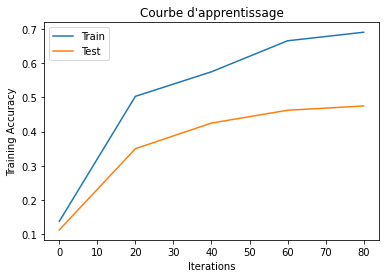

Précision finale Train : 0.690625
Précision finale Test : 0.475


In [91]:
mlp_bn = MLPBN(50)
train(mlp_bn , optimizer="adam", learning_rate=0.0001, momentum=0., num_epochs=10)

MLPBNBeforeReLu

In [122]:
class MLPBNBeforeReLu(nn.Module):
    def __init__(self, num_hidden):
        super(MLPBNBeforeReLu, self).__init__()
        self.layer1 = nn.Linear(128*216, num_hidden)
        self.bn = nn.BatchNorm1d(num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1,128*216) # flatten 
        activation1 = self.layer1(flattened)
        activation1 = self.bn(activation1)
        activation1 = torch.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

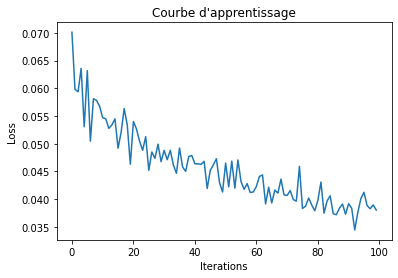

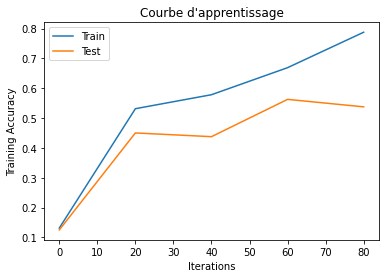

Précision finale Train : 0.7875
Précision finale Test : 0.5375


In [113]:
MLPBNBeforeReLu = MLPBNBeforeReLu(50)
train(MLPBNBeforeReLu, optimizer="adam", learning_rate=0.0001, momentum=0.9, num_epochs=10)

sgd

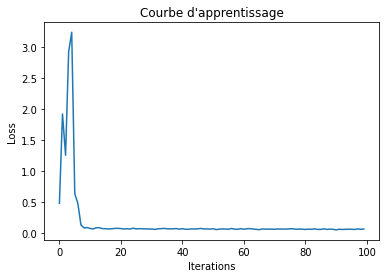

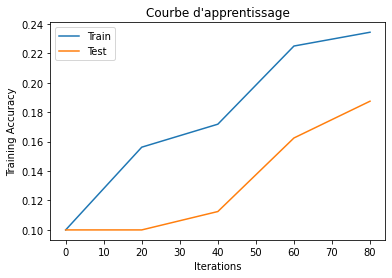

Précision finale Train : 0.234375
Précision finale Test : 0.1875


In [92]:
model = MLP(50)
train(model , optimizer="sgd", learning_rate=0.0001, momentum=0.9, num_epochs=10)

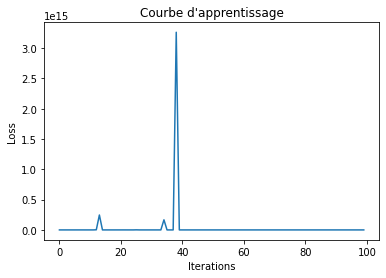

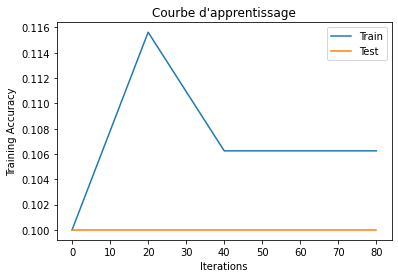

Précision finale Train : 0.10625
Précision finale Test : 0.1


In [93]:
model = MLP(50)
train(model , optimizer="sgd", learning_rate=0.1, momentum=0.9, num_epochs=10)

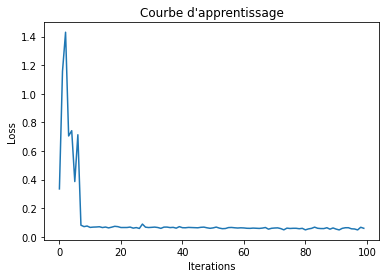

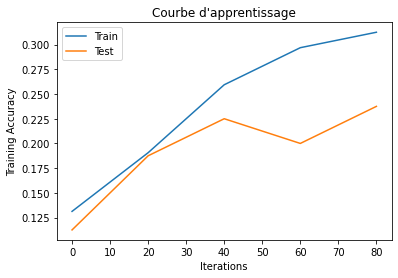

Précision finale Train : 0.3125
Précision finale Test : 0.2375


In [94]:
model = MLP(50)
train(model , optimizer="sgd", learning_rate=0.0001, momentum=0., num_epochs=10)

Batch Normalization (adam)


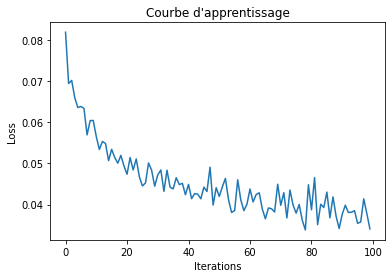

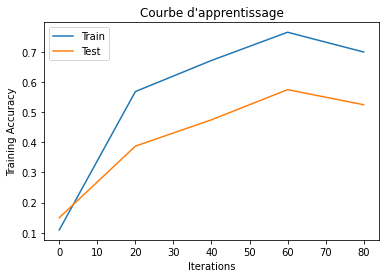

Précision finale Train : 0.7
Précision finale Test : 0.525


In [98]:
mlp_bn = MLPBN(50)
train(mlp_bn, optimizer="sgd", learning_rate=0.0001, momentum=0.9, num_epochs=10)

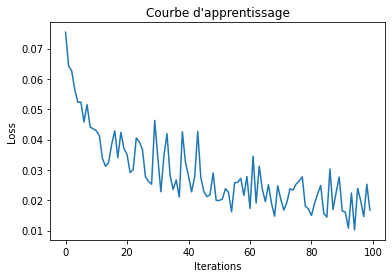

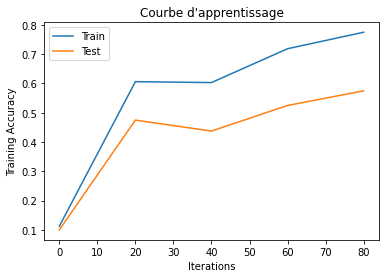

Précision finale Train : 0.775
Précision finale Test : 0.575


In [99]:
mlp_bn = MLPBN(50)
train(mlp_bn, optimizer="sgd", learning_rate=0.1, momentum=0.9, num_epochs=10)

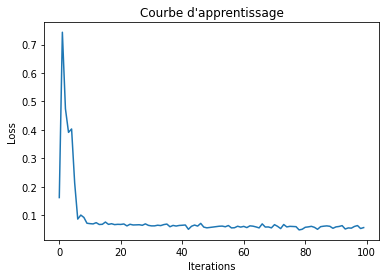

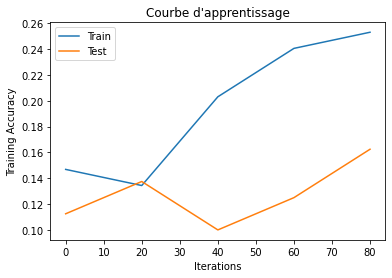

Précision finale Train : 0.253125
Précision finale Test : 0.1625


In [100]:
model = MLP(50)
train(model , optimizer="sgd", learning_rate=0.0001, momentum=0., num_epochs=10)

MLPBNBeforeReLu+sgd

In [124]:
class MLPBNBeforeReLu(nn.Module):
    def __init__(self, num_hidden):
        super(MLPBNBeforeReLu, self).__init__()
        self.layer1 = nn.Linear(128*216, num_hidden)
        self.bn = nn.BatchNorm1d(num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1,128*216) # flatten 
        activation1 = self.layer1(flattened)
        activation1 = self.bn(activation1)
        activation1 = torch.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

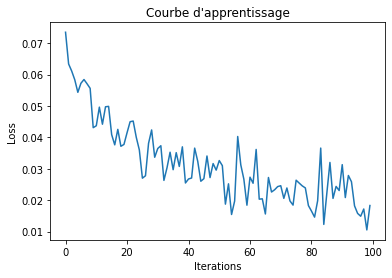

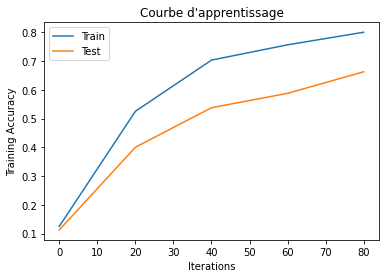

Précision finale Train : 0.8
Précision finale Test : 0.6625


In [125]:
MLPBNBeforeReLu = MLPBNBeforeReLu(50)
train(MLPBNBeforeReLu, optimizer="sgd", learning_rate=0.1, momentum=0.9, num_epochs=10)

On voit que le MLP n'est pas performant. Vous pourrez durant le temps que vous avez pour préparer le rapport essayer de modifier son architecture pour tenter d'améliorer ses performances.


Passons à un réseau convolutif, un CNN. 

Compléter son implémentation ci-dessous pour définir trois couches de convolution avec des noyaux de taille 3x3 et à 8, 16 et 32 canaux en sortie respectivement. 

Compléter les dimensions qui vont bien pour les deux couches fully-connected fc1 et fc2. fc1 a 50 neurones et fc2 10 neurones pour les 10 classes. 

Une ReLU sera appliquée après chaque couche de convolution et après fc1. 

Le pooling s'applique après chaque couche de convolution.

Compléter la méthode forward. Vous pouvez afficher les dimensions de la sortie de la dernière couche de convolution, après le pooling, pour déterminer la dimension que vous devez règler pour la couche fc1.


In [101]:
class CNN(nn.Module):
  #https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd
  #https://stackoverflow.com/questions/56660546/how-to-select-parameters-for-nn-linear-layer-while-training-a-cnn
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=8,
                               kernel_size=3,stride=1)   
        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3,stride=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        # conv          maxpool    conv         maxpool     conv       maxpool
        #128-3+1=126...126/2=63...63-3+1=61...61/2=30.5...30-3+1=28...28/2=14
        #216-3+1=214...214/2=107...107-3+1=105...105/2=52.5...52-3+1=50...50/2=25
        self.fc1 = nn.Linear(14*25*32, 50)
        self.fc2 = nn.Linear(50 , 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 14*25*32)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# https://qastack.fr/datascience/22760/number-and-size-of-dense-layers-in-a-cnn
# https://www.machinecurve.com/index.php/2021/01/26/creating-a-multilayer-perceptron-with-pytorch-and-lightning/

In [133]:
class CNNBN(nn.Module):
    def __init__(self):
        super(CNNBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=8,
                               kernel_size=3,stride=1) 
        self.bn1 = nn.BatchNorm2d(8) # nb de channels out
        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=3,stride=1)
        self.bn2 = nn.BatchNorm2d(16) # nb de channels out
        self.conv3 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3,stride=1)
        self.bn3 = nn.BatchNorm2d(32) # nb de channels out
        self.pool = nn.MaxPool2d(2, 2)

        # conv          maxpool    conv         maxpool     conv       maxpool
        #128-3+1=126...126/2=63...63-3+1=61...61/2=30.5...30-3+1=28...28/2=14
        #216-3+1=214...214/2=107...107-3+1=105...105/2=52.5...52-3+1=50...50/2=25
        self.fc1 = nn.Linear(14*25*32, 50)
        self.fc2 = nn.Linear(50 , 10)

    def forward(self, x):
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(x)

        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.pool(x)

        x = self.bn3(torch.relu(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 14*25*32)
        x = F.relu(self.fc1(x))
        return self.fc2(x)



Instancier le modèle CNN et afficher son nombre de paramètres

In [102]:
model = CNN()

Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

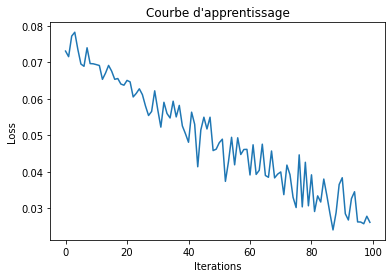

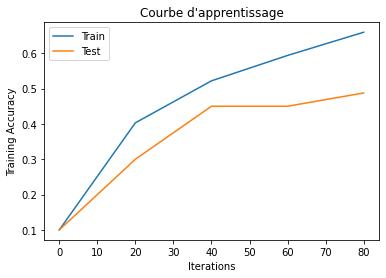

Précision finale Train : 0.659375
Précision finale Test : 0.4875


In [103]:
train(model, optimizer="adam", learning_rate=0.0001,momentum=0.9, num_epochs=10)

MLPBNBeforeReLu

In [134]:
mlp_bn = CNNBN()

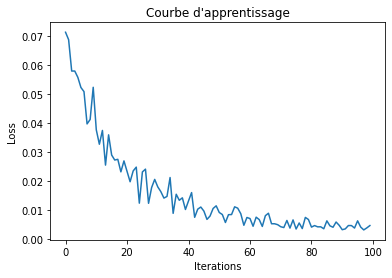

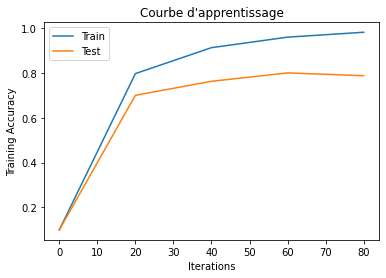

Précision finale Train : 0.98125
Précision finale Test : 0.7875


In [135]:
train(mlp_bn, optimizer="adam", learning_rate=0.0001,momentum=0.9, num_epochs=10)

Essayer d'obtenir les meilleurs scores possibles avec le MLP (si possible...) et surtout avec le CNN en modifiant leur architecture et en jouant avec les paramètres d'apprentissage de la fonction train.

Essayer les deux optimiseurs proposés. L'un est-il meilleur que l'autre ?

Une fois que vous avez votre meilleur modèle, faites une matrice de confusion qui montre les pourcentages de confusion entre les 10 classes sur le jeu de test.

intro
donnee
def MLP et CNN (avec explication code)
resultat(comparesant)
conclusion



